Extraemos caracteristicas de cada uno de los audios

In [1]:
import librosa
import numpy as np
import os
import csv

def extract_features(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path)

    # Calculate ZCR
    zcr = librosa.feature.zero_crossing_rate(y)[0].mean()

    # Calculate spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0].mean()

    # Calculate spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(
        y=y, sr=sr, roll_percent=0.85)[0].mean()

    # Calculate MFCC average
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_avg = np.mean(mfccs)

    return zcr, spectral_centroid, spectral_rolloff, mfcc_avg

def process_directory(directory):
    results = []
    for subdir, dirs, files in os.walk(directory):
        tipo = os.path.basename(subdir)  # Obtiene el nombre del subdirectorio actual
        for file in files:
            if file.endswith(".wav"):  # Procesa solo archivos .wav
                audio_path = os.path.join(subdir, file)
                zcr, spectral_centroid, spectral_rolloff, mfcc_avg = extract_features(audio_path)
                results.append([tipo, file, zcr, spectral_centroid, spectral_rolloff, mfcc_avg])

    # Guardar los resultados en un archivo CSV
    with open('caracteristicas_audio.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Tipo', 'Nombre Audio', 'ZCR', 'Spectral Centroid', 'Spectral Rolloff', 'MFCC Avg'])
        writer.writerows(results)

# Directorio principal donde están los subdirectorios con audios
directory = '/content/drive/MyDrive/audios'
process_directory(directory)


normalizamos las caracteristicas

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def main():
    # Ruta del archivo CSV
    csv_file_path = 'caracteristicas_audio.csv'

    # Leer el archivo CSV
    df = pd.read_csv(csv_file_path)

    # Mostrar el contenido original del DataFrame
    print("Contenido original del DataFrame:")
    print(df)

    # Crear una lista de las columnas que deseas normalizar
    columns_to_normalize = ['ZCR', 'Spectral Centroid', 'Spectral Rolloff', 'MFCC Avg']

    # Verificar si todas las columnas existen en el DataFrame
    for col in columns_to_normalize:
        if col not in df.columns:
            print(f"Warning: La columna '{col}' no existe en el archivo CSV.")

    # Filtrar las columnas que existen en el DataFrame
    columns_to_normalize = [col for col in columns_to_normalize if col in df.columns]

    # Normalizar las columnas especificadas
    scaler = MinMaxScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    # Mostrar el contenido del DataFrame normalizado
    print("\nContenido del DataFrame normalizado:")
    print(df)

    # Guardar el DataFrame normalizado en un nuevo archivo CSV si es necesario
    df.to_csv('caracteristicas_audio_normalizado.csv', index=False)

if __name__ == "__main__":
    main()


Contenido original del DataFrame:
        Tipo     Nombre Audio       ZCR  Spectral Centroid  Spectral Rolloff  \
0     cuatro  digitos_037.wav  0.038513         971.903927       1672.860718   
1     cuatro  digitos_056.wav  0.038555        1164.060322       2170.298415   
2     cuatro  digitos_034.wav  0.044608        1228.255416       2414.025879   
3     cuatro  digitos_015.wav  0.049417        1346.653973       2580.817727   
4     cuatro  digitos_039.wav  0.042824        1024.451020       1809.985352   
...      ...              ...       ...                ...               ...   
1583   cinco  digitos_929.wav  0.147644        2509.833025       4406.423950   
1584   cinco  digitos_948.wav  0.166947        2700.295189       4621.125545   
1585   cinco  digitos_863.wav  0.152832        2492.411944       4512.142281   
1586   cinco  digitos_892.wav  0.074392        1773.668756       3270.615707   
1587   cinco  digitos_954.wav  0.194226        2904.514810       4645.788574   

     

separamos las caracteristicas entre un conjunto de prueba que será de un 10% de las caracteristicas normalizadas y el otro 90% será usado para el aprendizaje

In [3]:
import pandas as pd

# Paso 1: Leer el archivo CSV original
csv_file_path = 'caracteristicas_audio_normalizado.csv'
df = pd.read_csv(csv_file_path)

# Paso 2: Calcular el número total de registros para cada tipo de audio
tipo_count = df['Tipo'].value_counts()

# Paso 3: Crear DataFrames para almacenar los datos del 10% y del 90%
df_10_percent = pd.DataFrame()
df_90_percent = pd.DataFrame()

# Paso 4: Iterar sobre cada tipo de audio y seleccionar el 10% de los registros
for tipo in tipo_count.index:
    # Calcular el número de registros para este tipo de audio
    count_total = tipo_count[tipo]

    # Calcular el número de registros para el 10%
    count_10_percent = round(count_total * 0.1)

    # Seleccionar el 10% de los registros para este tipo de audio
    subset = df[df['Tipo'] == tipo].sample(n=count_10_percent, replace=False)

    # Agregar este subconjunto al DataFrame del 10%
    df_10_percent = pd.concat([df_10_percent, subset])

    # Restar los registros seleccionados del DataFrame original para el 90%
    df_90_percent = pd.concat([df_90_percent, df[df['Tipo'] != tipo]])

# Paso 5: Guardar los DataFrames en nuevos archivos CSV con los nombres deseados
# Guardar el DataFrame del 10% en un nuevo archivo CSV llamado "conjunto de prueba"
df_10_percent.to_csv('conjunto_de_prueba.csv', index=False)

# Guardar el DataFrame del 90% en otro nuevo archivo CSV llamado "conjunto de aprendizaje"
df_90_percent.to_csv('conjunto_de_aprendizaje.csv', index=False)


creamos nuestra red neuronal para ver como funciona en estos casos

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5931 - loss: 0.9106 
Test Loss: 0.9181605577468872, Test Accuracy: 0.5696202516555786


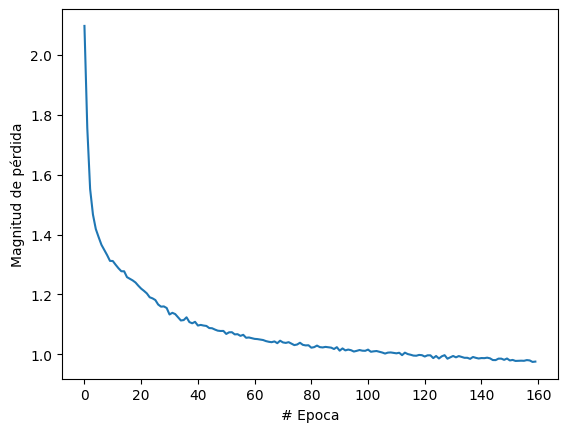

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Audio: digitos_2603.wav, True Tipo: cinco, Predicted Tipo: tres, Probability: 0.33
Audio: digitos_154.wav, True Tipo: cinco, Predicted Tipo: siete, Probability: 0.37
Audio: digitos_1609.wav, True Tipo: cinco, Predicted Tipo: cinco, Probability: 0.72
Audio: digitos_767.wav, True Tipo: cinco, Predicted Tipo: cinco, Probability: 0.58
Audio: digitos_4052.wav, True Tipo: cinco, Predicted Tipo: dos, Probability: 0.30
Audio: digitos_1068.wav, True Tipo: cinco, Predicted Tipo: cinco, Probability: 0.70
Audio: digitos_2858.wav, True Tipo: cinco, Predicted Tipo: dos, Probability: 0.31
Audio: digitos_634.wav, True Tipo: cinco, Predicted Tipo: dos, Probability: 0.42
Audio: digitos_3765.wav, True Tipo: cinco, Predicted Tipo: cinco, Probability: 0.68
Audio: digitos_1181.wav, True Tipo: cinco, Predicted Tipo: cinco, Probability: 0.62
Audio: digitos_3014.wav, True Tipo: cinco, Predicted Tipo: cinco, Probability: 0.67
Audio: digitos_5040.wav, True Tipo: cinco, Predi

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Cargar los archivos CSV
aprendizaje_csv_file_path = '/content/conjunto_de_aprendizaje.csv'
prueba_csv_file_path = '/content/conjunto_de_prueba.csv'
df_aprendizaje = pd.read_csv(aprendizaje_csv_file_path)
df_prueba = pd.read_csv(prueba_csv_file_path)

# Separar características (X) y etiquetas (y) para el conjunto de aprendizaje
X_train = df_aprendizaje.drop(['Tipo', 'Nombre Audio'], axis=1).values.astype(np.float32)
y_train = df_aprendizaje['Tipo'].values

# Separar características (X) y etiquetas (y) para el conjunto de prueba
X_test = df_prueba.drop(['Tipo', 'Nombre Audio'], axis=1).values.astype(np.float32)
y_test = df_prueba['Tipo'].values
nombre_audio_test = df_prueba['Nombre Audio'].values

# Convertir las etiquetas a números enteros
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)  # Usar el mismo codificador para las etiquetas de prueba

# Definir el modelo de red neuronal en TensorFlow
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(70, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])

# Compilar el modelo con una tasa de aprendizaje menor
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Implementar early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con el conjunto de aprendizaje
historial = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.1, verbose=0, callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Visualizar la evolución de la pérdida durante el entrenamiento
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])
plt.show()

# Realizar predicciones sobre el conjunto de prueba
predictions = model.predict(X_test)

# Obtener la etiqueta predicha y la probabilidad
predicted_labels = np.argmax(predictions, axis=1)
predicted_probabilities = np.max(predictions, axis=1)

# Decodificar las etiquetas predichas
predicted_labels_names = le.inverse_transform(predicted_labels)

# Imprimir los resultados
for nombre_audio, true_label, predicted_label, probability in zip(nombre_audio_test, y_test, predicted_labels_names, predicted_probabilities):
    true_label_name = le.inverse_transform([true_label])[0]
    print(f'Audio: {nombre_audio}, True Tipo: {true_label_name}, Predicted Tipo: {predicted_label}, Probability: {probability:.2f}')


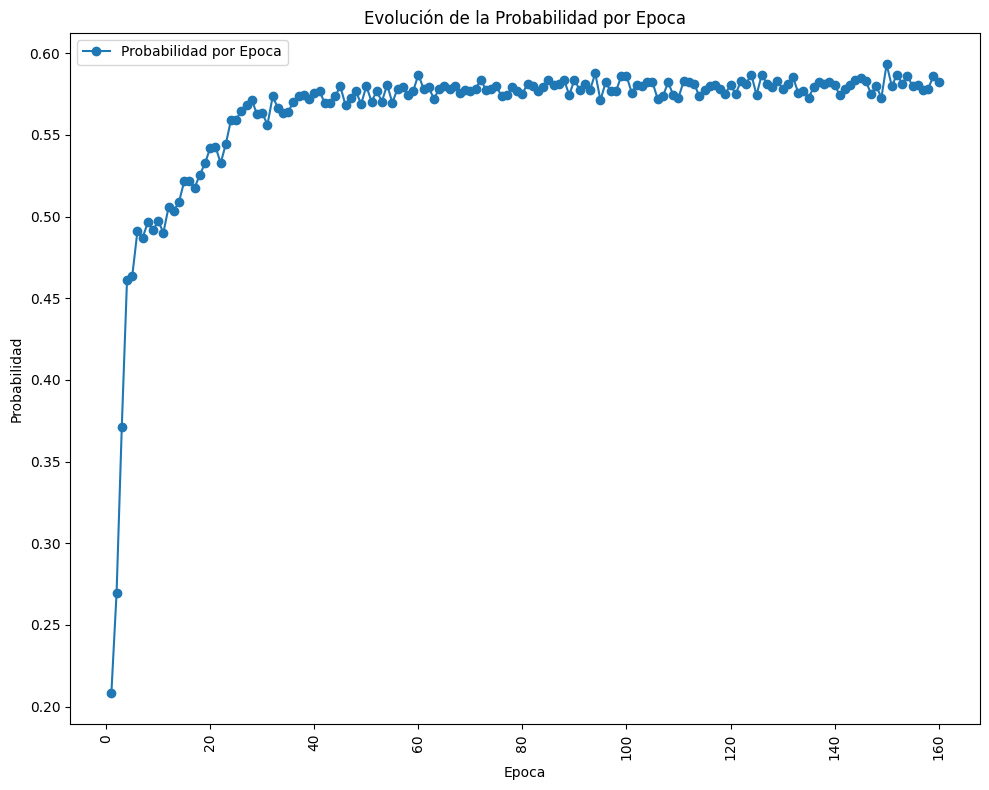

In [20]:
import matplotlib.pyplot as plt

# Obtener los datos del historial de entrenamiento
epochs = range(1, len(historial.history["loss"]) + 1)
probabilidades_epoca = historial.history["val_accuracy"]  # O podrías usar "accuracy"

# Crear una gráfica
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(epochs, probabilidades_epoca, 'o-', label='Probabilidad por Epoca')
ax.set_xlabel('Epoca')
ax.set_ylabel('Probabilidad')
ax.set_title('Evolución de la Probabilidad por Epoca')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

